In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [11]:
# polychronization_core.py
import numpy as np

# -----------------------------
# Build network (matches spnet.m)
# -----------------------------
def build_network(Ne=800, Ni=200, M=100, D=20, sm=10.0, seed=1):
    rng = np.random.default_rng(seed)
    N = Ne + Ni

    # Izhikevich neuron params
    a = np.concatenate([0.02*np.ones(Ne), 0.10*np.ones(Ni)])
    d = np.concatenate([8.0*np.ones(Ne), 2.0*np.ones(Ni)])

    # Postsynaptic targets: excitatory -> any neuron; inhibitory -> excitatory only
    post = np.empty((N, M), dtype=np.int32)
    post[:Ne, :] = rng.integers(0, N, size=(Ne, M))
    post[Ne:, :] = rng.integers(0, Ne, size=(Ni, M))  # inhibitory → excitatory only

    # Synaptic weights & derivatives
    s  = np.zeros((N, M), dtype=np.float32)
    s[:Ne, :] =  6.0     # excitatory
    s[Ne:, :] = -5.0     # inhibitory
    sd = np.zeros_like(s)

    # Conduction delays: each excitatory neuron spreads its M synapses across D slots; inhibitory are 1 ms
    delays = [[None]*D for _ in range(N)]
    per = M // D
    for i in range(N):
        if i < Ne:
            for j in range(D):
                delays[i][j] = np.arange(j*per, (j+1)*per, dtype=np.int32)
        else:
            delays[i][0] = np.arange(M, dtype=np.int32)
            for j in range(1, D):
                delays[i][j] = np.empty(0, dtype=np.int32)

    # Precompute incoming lists for LTP updates: for each postsyn j, list of (pre_e, syn_idx, delay_ms)
    incoming = [[] for _ in range(N)]
    for e in range(Ne):              # excitatory only
        for dj in range(D):
            syn_idxs = delays[e][dj]
            if syn_idxs.size == 0:
                continue
            targets = post[e, syn_idxs]
            for m, j in zip(syn_idxs, targets):
                incoming[j].append((e, m, dj+1))  # delay in ms (1..D)

    return {
        "Ne": Ne, "Ni": Ni, "N": Ne+Ni, "M": M, "D": D, "sm": sm,
        "a": a, "d": d, "post": post, "s": s, "sd": sd, "delays": delays, "incoming": incoming
    }

# -----------------------------------------
# One-second simulation with STDP & delays
# -----------------------------------------
def simulate_seconds(net, secs=30, thalamic_rate_per_ms=1, seed=2, progress=True):
    import numpy as np
    rng = np.random.default_rng(seed)
    N, Ne, Ni, M, D, sm = net["N"], net["Ne"], net["Ni"], net["M"], net["D"], net["sm"]
    a, d = net["a"], net["d"]
    post, s, sd, delays, incoming = net["post"], net["s"], net["sd"], net["delays"], net["incoming"]

    # State
    v = -65.0*np.ones(N, dtype=np.float32)
    u = 0.2*v.copy()

    # STDP buffer (fixed sizes)
    STDP = np.zeros((N, 1002 + D), dtype=np.float32)  # was 1001+D; needs one extra col

    # Spike list keeps only recent D ms relative to current second
    firings = [(-D, 0)]  # sentinel
    last_sec_firings = None

    # Progress bar
    pbar = None
    milestones = max(1, secs // 20)
    if progress:
        try:
            from tqdm.auto import tqdm
            pbar = tqdm(total=secs, desc="Pretraining (s)")
        except Exception:
            print(f"Pretraining for {secs}s...")

    for sec in range(secs):
        # Wrap STDP history (fixed slice: copy D+1 columns)
        STDP[:, :D+1] = STDP[:, 1001:1002 + D]

        # 1000 ms in this second
        for t in range(1, 1001):  # 1..1000
            I = np.zeros(N, dtype=np.float32)
            if thalamic_rate_per_ms > 0:
                idx = rng.integers(0, N, size=thalamic_rate_per_ms)
                I[idx] += 20.0

            fired = np.where(v >= 30.0)[0]
            if fired.size > 0:
                v[fired] = -65.0
                u[fired] += d[fired]
                STDP[fired, t + D] = 0.1  # postsyn trace mark

                # LTP for incoming excitatory synapses of each fired postsyn
                for j in fired:
                    inc = incoming[j]
                    if not inc:
                        continue
                    e_idx  = np.fromiter((x[0] for x in inc), dtype=np.int32, count=len(inc))
                    m_idx  = np.fromiter((x[1] for x in inc), dtype=np.int32, count=len(inc))
                    dly_ms = np.fromiter((x[2] for x in inc), dtype=np.int32, count=len(inc))
                    sd[e_idx, m_idx] += STDP[e_idx, t + D - dly_ms]

            # Deliver spikes with axonal delays + LTD
            k = len(firings) - 1
            while firings[k][0] > t - D:
                t_pre, pre = firings[k]
                dj = t - t_pre  # 1..D
                syn_idxs = delays[pre][dj-1]
                if syn_idxs.size:
                    targets = post[pre, syn_idxs]
                    I[targets] += s[pre, syn_idxs]
                    sd[pre, syn_idxs] -= 1.2 * STDP[targets, t + D]
                k -= 1

            if fired.size > 0:
                firings.extend((t, int(n)) for n in fired)

            # Two half-steps
            v += 0.5*((0.04*v + 5.0)*v + 140.0 - u + I)
            v += 0.5*((0.04*v + 5.0)*v + 140.0 - u + I)
            u += a*(0.2*v - u)

            # STDP decay
            STDP[:, t + D + 1] = 0.95 * STDP[:, t + D]

        # Record last 1 s raster
        last_sec_firings = np.array([(tt, nn) for (tt, nn) in firings if 0 < tt <= 1000], dtype=np.int32)

        # Carry spikes across the boundary (so delayed deliveries beyond the second still land)
        firings = [(tt - 1000, nn) for (tt, nn) in firings if tt > 1000 - D]
        firings.insert(0, (-D, 0))  # sentinel

        # Clip & decay weights
        s[:Ne, :] = np.clip(0.01 + s[:Ne, :] + sd[:Ne, :], 0.0, sm)
        sd *= 0.9

        # Progress update
        if pbar:
            pbar.update(1)
        elif progress and ((sec + 1) % milestones == 0 or (sec + 1) == secs):
            print(f"{sec+1}/{secs} s")

    if pbar:
        pbar.close()

    net["s"]  = s
    net["sd"] = sd
    return last_sec_firings, v, u



In [12]:
# polychronization_groups.py
import numpy as np
from collections import defaultdict, deque

def detect_group_for_seed(i, j, tau_ms, post, delays, Ne, D, max_time=200):
    """
    Topology-only cascade: start with neuron i at t=0, neuron j at t=tau_ms.
    A neuron fires if >= 2 inputs land in the same millisecond.
    Returns list of (t, neuron) sorted by time if group size >= 3; else [].
    """
    N = post.shape[0]
    fired_times = {}  # neuron -> first spike time
    arrivals = defaultdict(int)  # (neuron, t) -> count
    q = deque()

    # seed events
    fired_times[i] = 0
    fired_times[j] = tau_ms
    q.append((i, 0))
    q.append((j, tau_ms))

    # schedule their outgoing arrivals
    def schedule_from(neuron, t_fire):
        # fan-out over each delay bucket
        for dj in range(D):
            syn_idxs = delays[neuron][dj]
            if syn_idxs.size == 0:
                continue
            t_arr = t_fire + (dj + 1)  # arrival time
            if t_arr > max_time:
                continue
            targets = post[neuron, syn_idxs]
            # increment arrival counts at time t_arr
            for tgt in targets:
                arrivals[(int(tgt), t_arr)] += 1

    schedule_from(i, 0)
    schedule_from(j, tau_ms)

    # process in time order
    # we iterate times incrementally to enforce exact coincidence rule
    for t in range(0, max_time+1):
        # which neurons receive >=2 arrivals at t and have not yet fired?
        cand = [n for (n, tt), c in arrivals.items() if tt == t and c >= 2 and n not in fired_times]
        if not cand:
            continue
        for n in cand:
            fired_times[n] = t
            schedule_from(n, t)

    # build spike list
    spikes = sorted([(t, n) for n, t in fired_times.items()], key=lambda x: (x[0], x[1]))
    # Require at least 3 distinct neurons (typical threshold); adjust as needed
    return spikes if len(spikes) >= 3 else []

def scan_random_seeds(post, delays, Ne, D, n_pairs=200, tau_grid=None, min_size=15, max_time=200, seed=0):
    """
    Randomly sample excitatory pairs and time offsets; return groups meeting min_size.
    """
    rng = np.random.default_rng(seed)
    if tau_grid is None:
        tau_grid = np.arange(1, D+1, dtype=int)

    groups = []
    for _ in range(n_pairs):
        i, j = rng.integers(0, Ne, size=2)
        if i == j:
            continue
        tau = int(rng.choice(tau_grid))
        g = detect_group_for_seed(i, j, tau, post, delays, Ne, D, max_time=max_time)
        if g and len(g) >= min_size:
            groups.append({"seed": (i, j, tau), "spikes": g})
    return groups


Pretraining (s):   0%|          | 0/300 [00:00<?, ?it/s]

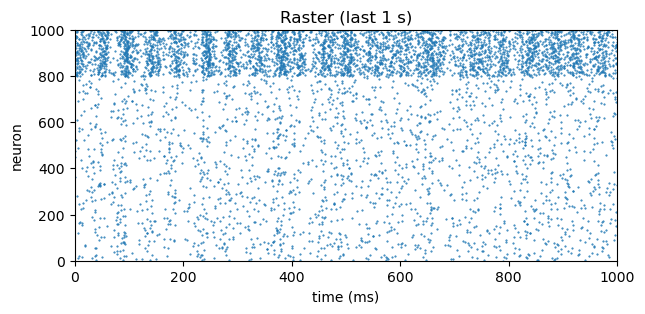

Found 468 groups with size ≥15 in 2000 random seeds.
Seed (i, j, tau): (np.int64(658), np.int64(758), 5)
Group size: 1000


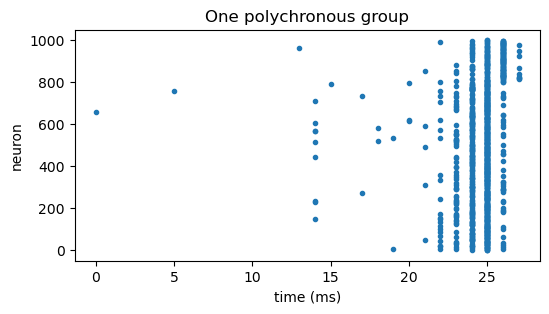

In [13]:
# === Train the network a bit ===
net = build_network(Ne=800, Ni=200, M=100, D=20, sm=10.0, seed=42)

# Pretrain synapses (start with e.g. 300 s; scale up as needed)
last_raster, v, u = simulate_seconds(net, secs=300, thalamic_rate_per_ms=2, seed=7)

# Optional: visualize last 1 s raster
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3))
if last_raster is not None and len(last_raster):
    plt.plot(last_raster[:,0], last_raster[:,1], '.', markersize=1)
plt.xlim(0,1000); plt.ylim(0, net["N"])
plt.xlabel('time (ms)'); plt.ylabel('neuron'); plt.title('Raster (last 1 s)')
plt.show()

# === Scan for polychronous groups on the trained topology ===
groups = scan_random_seeds(net["post"], net["delays"], net["Ne"], net["D"],
                           n_pairs=2000, tau_grid=np.arange(1, net["D"]+1),
                           min_size=15, max_time=200, seed=1)

print(f"Found {len(groups)} groups with size ≥15 in 2000 random seeds.")
# Inspect one group
if groups:
    g0 = groups[0]
    print("Seed (i, j, tau):", g0["seed"])
    print("Group size:", len(g0["spikes"]))
    # Plot spike times of the group
    ts = [t for t,n in g0["spikes"]]
    ns = [n for t,n in g0["spikes"]]
    plt.figure(figsize=(6,3))
    plt.plot(ts, ns, '.')
    plt.xlabel('time (ms)'); plt.ylabel('neuron'); plt.title('One polychronous group')
    plt.show()


In [15]:
last_raster.T

array([[   1,    1,    1, ...,  999, 1000, 1000],
       [ 361,  449,  474, ...,  962,  937,  946]],
      shape=(2, 6171), dtype=int32)

In [17]:
6171*300/70000

26.447142857142858